코더의 소회 :¶
날씨 : 오늘의 학습 < 화창☀️ >했습니다. [☀️⛅☁️🌧️🌩️⛈️]

**배운점 :**   
가중치 기울기 계산에 패딩이 어떤 영향을 주고, 기울기 값이 손실 값에 어떻게 영향을 주는 지 체험적으로 배웠다.  
**아쉬운점 :**  
딱히 없었다. 분석까지 해서 만족한다.  
**느낀점 :**   
지난 번 프로젝트에 이어서 컴퓨팅 성능의 중요성을 체감.   
(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr08)

**전체 코드 실행 플로우 (목차):**  
STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성   
STEP 2. klue/bert-base model 및 tokenizer 불러오기   
STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기   
STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기   
STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교   

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00


In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00


In [4]:
import datasets
from datasets import load_dataset
from evaluate import load as load_metric

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, get_linear_schedule_with_warmup

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import os
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
warnings.filterwarnings("once", module='matplotlib.font_manager')  # WARNING 메시지를 한 번만 출력하도록 설정
from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np
import pandas as pd
import multiprocessing

In [5]:

# 방법 1: os 모듈 사용
cpu_count_os = os.cpu_count()
print(f"CPU 코어 수 (os): {cpu_count_os}")

# 방법 2: multiprocessing 모듈 사용
cpu_count_mp = multiprocessing.cpu_count()
print(f"CPU 코어 수 (multiprocessing): {cpu_count_mp}")


# 한글설정
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

fontpath = '/usr/share/fonts/truetype/malgun/MalgunGothic.ttf'  # 변경된 한글 폰트 경로 # HERE
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='Malgun Gothic')  # 변경된 폰트 이름 # HERE
mpl.font_manager.findfont(font)

print("한글설정 완료!")

CPU 코어 수 (os): 12
CPU 코어 수 (multiprocessing): 12
한글설정 완료!


## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [6]:
## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성
dataset = load_dataset("nsmc")

# 훈련 데이터와 테스트 데이터 확인
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset[0])  # 첫 번째 훈련 데이터 예시 출력
print(test_dataset[0])   # 첫 번째 테스트 데이터 예시 출력
print('\n')
# 데이터 읽기 : Train DATASET 5줄만 확인
cols = train_dataset.column_names
print(cols)
print('\n')

for i in range(5):
    for col in cols:
        print(col, ":", train_dataset[col][i])
    print('\n')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

nsmc.py:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

The repository for nsmc contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nsmc.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}
{'id': '6270596', 'document': '굳 ㅋ', 'label': 1}


['id', 'document', 'label']


id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




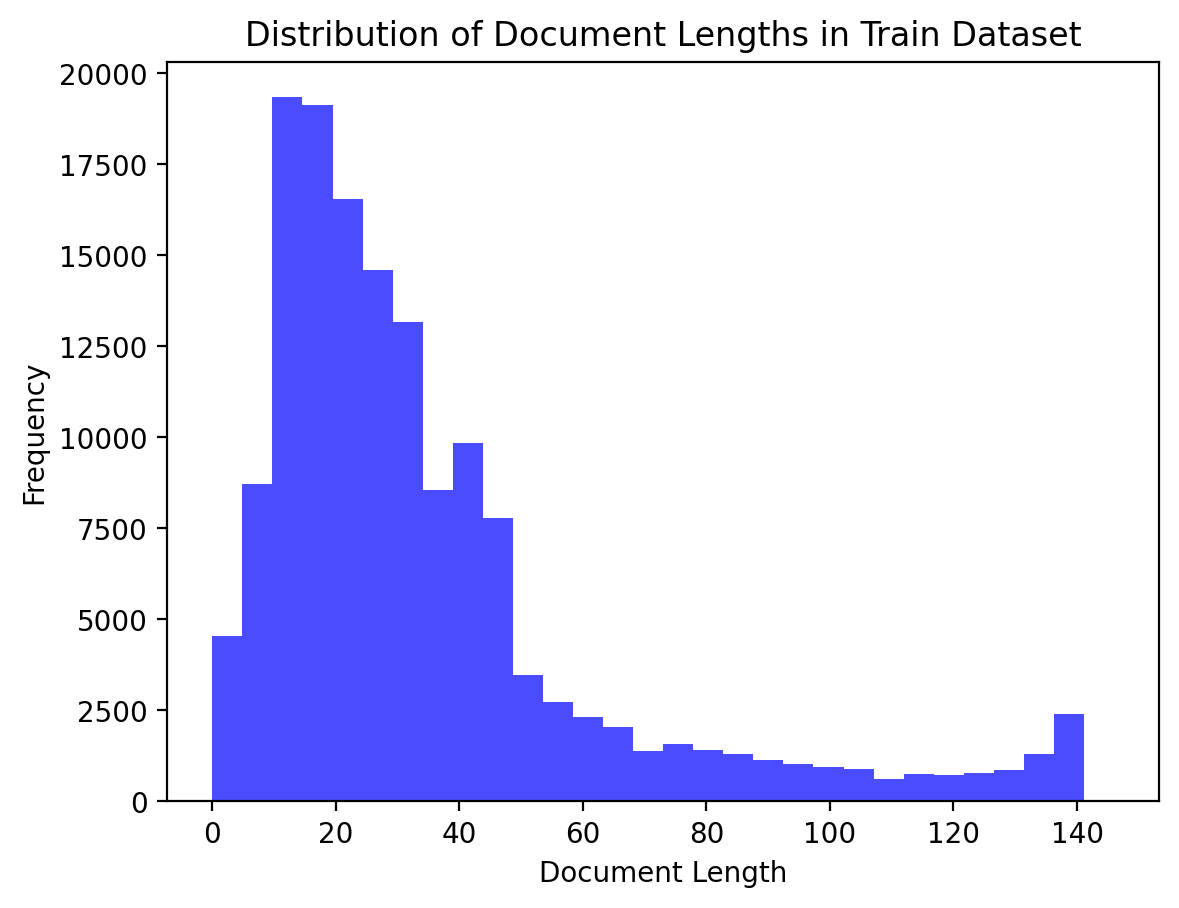

In [7]:
# 데이터 길이 분포 확인
train_lengths = [len(text) for text in train_dataset['document']]
plt.hist(train_lengths, bins=30, color='blue', alpha=0.7)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths in Train Dataset')
plt.show()

=> **토큰 max length는 128로 하기로 결정**

## STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [8]:
## STEP 2. klue/bert-base model 및 tokenizer 불러오기
# 모델, 토크나이저 불러오기
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

# 토큰화함수
def tokenize_function(dataframe):
    return tokenizer(
        dataframe['document'],
        padding='max_length',  # Pad sequences to the maximum length allowed by the model
        truncation=True,         # Truncate sequences that are too long
        max_length=128
    )

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## STEP 3. 불러온 tokenizer으로 데이터셋 전처리 & model 학습 진행하기

In [9]:
## STEP 3. 불러온 tokenizer으로 데이터셋 전처리 & model 학습 진행하기
# 토큰화함수로 dataset 토큰화
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=16)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=16)

# 가져오기 : accuracy metric
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)  # 가장 높은 예측값의 label index을 선택
    return accuracy_metric.compute(predictions=predictions, references = labels)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
## STEP 3. model 학습 진행하기

# Adjust hyperparameters to enhance model performance
# output_dir = os.getenv('HOME') + '/aiffel/transformers'
output_dir = './result'
training_arguments_1 = TrainingArguments(
    output_dir=output_dir,          # Save path
    evaluation_strategy="epoch",    # Evaluation frequency
    learning_rate=2e-5,             # Increased learning rate for potential improvement
    per_device_train_batch_size=8, # Increased batch size for better GPU utilization
    per_device_eval_batch_size=8,  # Increased evaluation batch size
    num_train_epochs=3,             # Increased number of epochs for more training
    weight_decay=0.01,              # Weight decay to prevent overfitting
    logging_dir='./logs',           # Directory for storing logs
    logging_steps=10,               # Log every 10 steps
)

# Create a new Trainer instance with updated arguments
trainer_not_tuned = Trainer(
    model=model,                      # Model to train
    args=training_arguments_1,           # Updated training arguments
    train_dataset=tokenized_train_dataset,  # Tokenized training dataset
    eval_dataset=tokenized_test_dataset,    # Tokenized evaluation dataset
    compute_metrics=compute_metrics,   # Metrics for evaluation
)

# Train the not-tuned model
print("Fine-tuning the model...")
trainer_not_tuned.train()
# Evaluate the not-tuned model
print("Evaluating the not-tuned model...")
evaluation_results_not = trainer_not_tuned.evaluate()
print(f"Evaluation results of not-tuned model : {evaluation_results_not}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Fine-tuning the model...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.139300,0.283786,0.900640
2,0.418300,0.342093,0.906220
3,0.141200,0.465562,0.905140


Evaluating the not-tuned model...


Evaluation results of not-tuned model : {'eval_loss': 0.46556156873703003, 'eval_accuracy': 0.90514, 'eval_runtime': 183.725, 'eval_samples_per_second': 272.146, 'eval_steps_per_second': 34.018, 'epoch': 3.0}


## STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

#### <조건 비교 : 시도 #01 -> **#02**>   
TrainingArguments Changes
- learning_rate = 2e-5 → **"3e-5"**   
- per_device_train_batch_size = 8 → **"16"**    
- per_device_eval_batch_size = 8 → **"16"**  
- num_train_epochs = 3 → "5"  

TrainingArguments Add  
*   logging_dir='./logs'
*   logging_steps=10
*   max_steps=int**(0.5 * 56250)**

⇒ 코랩에서 성능 좋은 GPU사용하여,   
전반적인 _**처리속도 개선** 효과뿐만 아니라_,  
**WandB(tool)* 사용**하여 fine-tuning 전후나 buketing 결과물을 대시보드로 한눈에 보고팠기에 옮김.  
(*그래서 logging_dir, logging_steps 추가함)  


---  

아무리 코랩이라도 **기존의 전체 학습은 무리가 되지 않을까**라는 기우에 다음과 같은 변화를 주었다.  


*   배치크기 늘리기 (학습처리 속도향상)
*   학습률 올리기 (학습처리 속도향상)
*   max_steps=int(0.5 * 56250) (학습량 줄이기)  



## STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

#### Bucketing을 적용하여 학습 & 평가하기

In [ ]:
# Import DataCollatorWithPadding for dynamic padding
from transformers import DataCollatorWithPadding

# Use DataCollatorWithPadding to dynamically pad the batches
# This ensures each batch is padded to the maximum sequence length within that batch, reducing padding overhead
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Update TrainingArguments to use bucketing by setting group_by_length=True
training_arguments_bucketing = TrainingArguments(
    output_dir=output_dir,  # Save path
    evaluation_strategy="epoch",  # Evaluation frequency
    learning_rate=3e-5,  # Learning rate
    per_device_train_batch_size=16,  # Training batch size per device
    per_device_eval_batch_size=16,  # Evaluation batch size per device
    num_train_epochs=5,  # Number of training epochs
    weight_decay=0.01,  # Weight decay
    group_by_length=True,  # Enable bucketing to group sequences of similar lengths
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    max_steps=int(0.5 * 56250),  # Train on 50% of the total steps # HERE
)

# Create a Trainer instance with bucketing and dynamic padding
trainer_bucketing = Trainer(
    model=model,                      # Model to train
    args=training_arguments_bucketing, # Training arguments with bucketing
    train_dataset=tokenized_train_dataset,  # Tokenized training dataset
    eval_dataset=tokenized_test_dataset,    # Tokenized evaluation dataset
    compute_metrics=compute_metrics,   # Metrics for evaluation
    data_collator=collator,            # Data collator for dynamic padding
)

# Train the model with bucketing and dynamic padding
print("Training the model with bucketing and dynamic padding...")
trainer_bucketing.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Training the model with bucketing and dynamic padding...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.197300,0.370215,0.897220
2,0.131500,0.469618,0.901580
3,0.014500,0.567347,0.903040


TrainOutput(global_step=28125, training_loss=0.10704499172260364, metrics={'train_runtime': 3018.8299, 'train_samples_per_second': 149.064, 'train_steps_per_second': 9.317, 'total_flos': 2.9599993728e+16, 'train_loss': 0.10704499172260364, 'epoch': 3.0})

In [ ]:
# Evaluate the model trained with bucketing
print("Evaluating the model trained with bucketing...")
evaluation_results_bucketing = trainer_bucketing.evaluate()
print(f"Evaluation results with bucketing: {evaluation_results_bucketing}")

Evaluating the model trained with bucketing...


Evaluation results with bucketing: {'eval_loss': 0.5673470497131348, 'eval_accuracy': 0.90304, 'eval_runtime': 96.3354, 'eval_samples_per_second': 519.02, 'eval_steps_per_second': 32.439, 'epoch': 3.0}


⇒ **빠르다!**

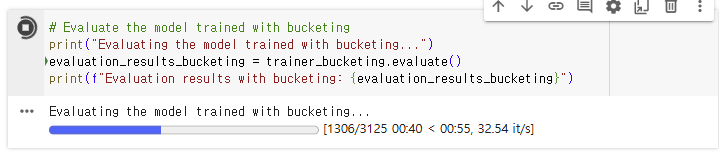

In [ ]:
!zip -r logs.zip ./logs
from google.colab import files
files.download("logs.zip")

  adding: logs/ (stored 0%)
  adding: logs/events.out.tfevents.1730352973.6f8480526973.7165.0 (deflated 71%)
  adding: logs/events.out.tfevents.1730361532.6f8480526973.7165.3 (deflated 27%)
  adding: logs/events.out.tfevents.1730356153.6f8480526973.7165.1 (deflated 26%)
  adding: logs/events.out.tfevents.1730358355.6f8480526973.7165.2 (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 결과비교 :  STEP 4 vs. STEP 5

TensorBoard로 보려했으나 깔끔하지 않아서 탈락

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs


In [ ]:
print(evaluation_results)
print(evaluation_results_bucketing)

{'eval_loss': 0.3952576816082001, 'eval_accuracy': 0.90502, 'eval_runtime': 95.5577, 'eval_samples_per_second': 523.244, 'eval_steps_per_second': 32.703, 'epoch': 3.0}
{'eval_loss': 0.5673470497131348, 'eval_accuracy': 0.90304, 'eval_runtime': 96.3354, 'eval_samples_per_second': 519.02, 'eval_steps_per_second': 32.439, 'epoch': 3.0}


테이블로 결과 비교해보기로 함

In [ ]:
data_eval = {
    "Metric" : list(evaluation_results.keys()),
    "Fine-tuned Mdl" : list(evaluation_results.values()),
    "Busketing Mdl" : list(evaluation_results_bucketing.values())
}

# DataFrame 생성 및 스타일 적용
comparison_df = pd.DataFrame(data_eval)
comparison_df_styled = comparison_df.style.set_table_styles(
    [{'selector': 'table', 'props': [('border', '2px solid black')]},
     {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('border', '1px solid black')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_properties(**{
    'text-align': 'center'
})

# 테이블 출력
from IPython.display import display
print("Comparison of Fine-tuned Model and Bucketing Model:")
display(comparison_df_styled)

Comparison of Fine-tuned Model and Bucketing Model:


,Metric,Fine-tuned Mdl,Busketing Mdl
0,eval_loss,0.395258,0.567347
1,eval_accuracy,0.905020,0.903040
2,eval_runtime,95.557700,96.335400
3,eval_samples_per_second,523.244000,519.020000
4,eval_steps_per_second,32.703000,32.439000
5,epoch,3.000000,3.000000


#### [분석] _**"아니 왜 `eval_loss'가 0.17이나 차이나지??"**_

배치마다 약간의 기울기 계산(가중치) 변화 생기고 이 변화로 `eval_loss'도 변화가 생김!  
버킷화로 인해 각 배치의 데이터 구성이 매번 달라지면서, 모델이 새로운 데이터에 맞추려다 보면 손실이 더 높아진 것으로 예상한다.   

---
**FYI**  
 bucketing을 사용하면 비슷한 길이의 시퀀스를 한 배치로 구성할 수 있는데, 비슷한 길이의 시퀀스가 모여있으니 패딩을 줄이게 되어 처리 속도를 개선할 수 있다. _그러나 이렇게 배치 구성이 바뀌면_ 각 **배치마다 약간의 기울기 계산(가중치) 변화**가 생기고, 이로 인해 **오차 계산(손실)이 달라져** eval_loss가 높아질 수 있다!

( _기울기 계산 방식 변화가 생기는게 왜 오차 계산(손실)이 달라진다?_  
한 배치 내 비슷한 길이 데이터 있어 **패딩이 줄어들면** 짧은 문장에 끝 빈공간(0)들이 문장에서 줄어들어 **모델은 빈공간보다 실제 단어들을 더 많이 학습**함. 가중치는 학습결과에 따라 가중치 조정하기에 이러한 **학습 조건의 차이가 손실함수의 차이를 가져온 것**으로 보인다.)
